In [222]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

In [223]:
import warnings
warnings.simplefilter(action='ignore')

In [224]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                 "ytick.direction": "in"})
    rcparams = {'text.usetex': usetex,
              'font.family': 'sans-serif',
              'font.sans-serif': ['Helvetica'],
             # 'text.latex.unicode': True,
              'text.latex.preamble': [r"\usepackage[T1]{fontenc}",
                                      r"\usepackage{lmodern}",
                                      r"\usepackage{amsmath}",
                                      r"\usepackage{mathptmx}"
                                      ],
              'axes.labelsize': 30,
              'axes.titlesize': 30,
              'ytick.right': 'on',
              'xtick.top': 'on',
              'xtick.labelsize': '25',
              'ytick.labelsize': '25',
              'axes.linewidth': 1.8,
              'xtick.major.width': 1.8,
              'xtick.minor.width': 1.8,
              'xtick.major.size': 14,
              'xtick.minor.size': 7,
              'xtick.major.pad': 10,
              'xtick.minor.pad': 10,
              'ytick.major.width': 1.8,
              'ytick.minor.width': 1.8,
              'ytick.major.size': 14,
              'ytick.minor.size': 7,
              'ytick.major.pad': 10,
              'ytick.minor.pad': 10,
              'axes.labelpad': 15,
              'axes.titlepad': 15,
              "xtick.direction": "in",
              "ytick.direction": "in",
              'legend.fontsize': 20}
    mpl.rcParams.update(rcparams) 

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = '#3690c0'

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize

def custom_frame(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='x',length=10,direction='out')
    ax.tick_params(axis='x',which='minor',direction='out')
    ax.tick_params(axis='y',length=10,direction='out')
    ax.tick_params(axis='y',which='minor',direction='out')

In [225]:
import pickle
import itertools
import math
import random
import pandas as pd
import numpy as np
import networkx as nx

from datetime import date

In [226]:
def make_node_name(node):
    node = node.title()
    text = node.split('_')    
    if len(text)<3:
        return ','.join([text[0],text[1].upper()])
    else:
        city = ' '.join(text[0:-1])
        state = text[-1]
        state = state.upper()
        return ','.join([city,state])

In [227]:
df_air = pd.read_pickle('../data/networks/US_air_1990_2018.pkl')
nodes = set(df_air.source.unique())|set(df_air.target.unique())
df_air = df_air[df_air.source != df_air.target]
year = list(df_air.index.get_level_values(0).unique())
month = list(df_air.index.get_level_values(1).unique())
graphs_air = []
date_air = []
for y in year:
    for m in month:
#        if y != 2018 or m != 12:
        df = df_air.loc[y,m]
        date_air.append(date(y,m,1))
        G = nx.from_pandas_edgelist(df_air.loc[y,m], edge_attr=True)
        G.add_nodes_from(nodes)
        graphs_air.append(G)
        

n = date_air.index(date(2004,1,1))
graphs_air = graphs_air[n:]
date_air =  date_air[n:]

del df_air

In [228]:
import datetime
import calendar

def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)

In [229]:
import glob, os

files = glob.glob('../simulation4/results/*.pickle.dat')+ glob.glob('../simulation4/results0/*.pickle.dat')

In [9]:
df = pd.DataFrame()#{'time':[],'Nedges':[],'Gcc':[]})
N = graphs_air[-1].number_of_nodes()

for f in files:
    graphs_prediction = pickle.load(open(f,'rb'))
    df_temp = pd.DataFrame({})
    
    df_temp['time'] = [add_months(date_air[-1],j) for j in range(len(graphs_prediction))]
    df_temp['Nedges'] = [G.number_of_edges() for G in graphs_prediction]
    df_temp['Gcc'] = [max(nx.connected_component_subgraphs(G),key=len).number_of_nodes()/N for G in graphs_prediction]
    df_temp['Niso'] = [len(list(nx.isolates(G))) for G in graphs_prediction]
    if 'null' in f:
        df_temp['graph'] = ['null'] *len(graphs_prediction)
    else:
        df_temp['graph'] = ['model'] *len(graphs_prediction)
    df_temp['Nend'] = [f.strip('.pickle.dat').split('_')[-1].strip('Nend')[0:4]] *len(graphs_prediction)
    df_temp['gamma'] = [f.strip('.pickle.dat').split('_')[-2].strip('gamma')] *len(graphs_prediction)
    df = df.append(df_temp)

In [10]:
df.head()

,time,Nedges,Gcc,Niso,graph,Nend,gamma
0,2018-12-01,6016,0.389085,1204,null,3000,0.05
1,2019-01-01,5869,0.385548,1211,null,3000,0.05
2,2019-02-01,5730,0.383527,1216,null,3000,0.05
3,2019-03-01,5597,0.382011,1219,null,3000,0.05
4,2019-04-01,5471,0.377969,1227,null,3000,0.05


In [51]:
data = df[df.Nend=='2000']
data = data[data.gamma!='50']
data = data[data.gamma!='10']
data = data[data.gamma!='0.001']
data = data.sort_values(by='gamma')
# data['Nedges'] = np.log10(data.Nedges)

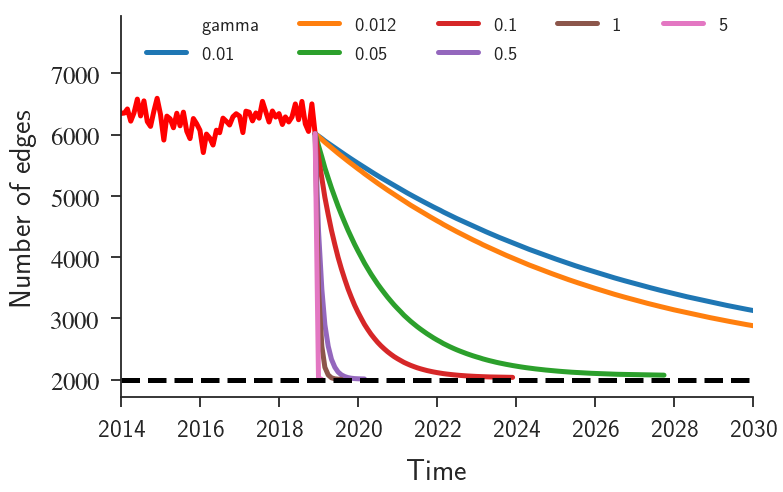

In [300]:
colors = sns.color_palette(None, 7)
fig,ax = plt.subplots(figsize=(xs,ys))
plt.plot(date_air,[G.number_of_edges() for G in graphs_air],c='r')
g = sns.lineplot(x="time", y="Nedges",hue='gamma',palette=colors, legend = 'full', 
             ci=95,n_boot=100,data=data[data.graph=='model'],ax=ax)
plt.xlabel('Time')
plt.ylabel("Number of edges")
plt.axhline(y=2000,linestyle='--',c='black')
plt.xlim(date(2014,1,1),date(2030,1,1))
# plt.legend(bbox_to_anchor=(1, 0.01))
# plt.title('Exponetial remove with N = 2000 in different rate')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=False, shadow=False,frameon=False)
custom_frame(ax)
# plt.yscale('log')
plt.savefig(f'../figures/exponential_remove_with_different_rate.pdf',transparent=True)
plt.show()

## Simulations
Starting with the latest air transportation network we have in the data, using the model we trained to predict which edges are going to be removed. We simulate the removal of edges in next 10 years (120 time steps). At each time step, the model will assign a value (0-1) to each edge. We remove the edges by chance using this value model predicted and a control parameter f (approximately it's the fraction of removal each time step).
## Result
The figure shows how long each edges will be removed in those 10 simulations. The x axis is the edges index. The y axis is survial time (after how long it is removed). The solid line is the average survival time of the 10 simulations and the gred shaded area being the 90 conffident interval

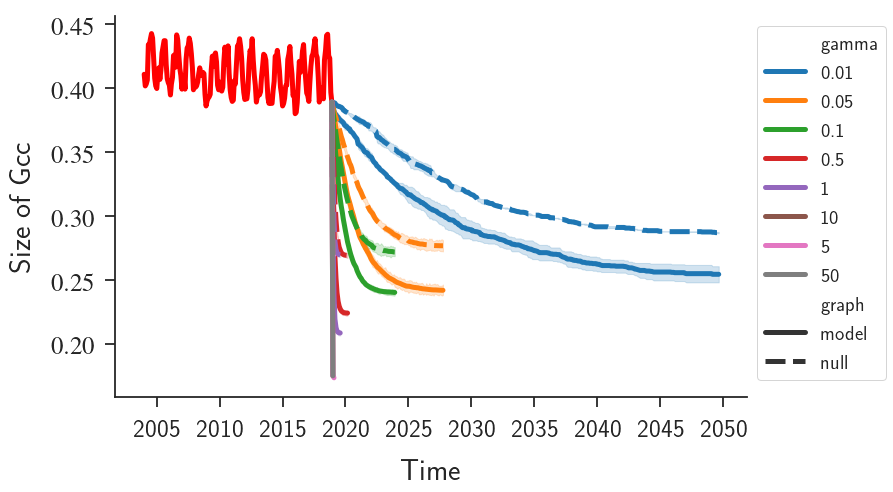

In [47]:
colors = sns.color_palette(None, 8)#['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f']
fig,ax = plt.subplots(figsize=(xs,ys))
plt.plot(date_air,[max(nx.connected_component_subgraphs(G),key=len).number_of_nodes()/N for G in graphs_air],c='r')
g = sns.lineplot(x="time", y="Gcc",hue='gamma', style='graph',palette=colors, legend = 'full', 
             ci=95,n_boot=100,data=df[df.Nend=='2000'],ax=ax)
plt.xlabel('Time')
plt.ylabel("Size of Gcc")
plt.legend(bbox_to_anchor=(1.0, 1))
custom_frame(ax)
plt.show()

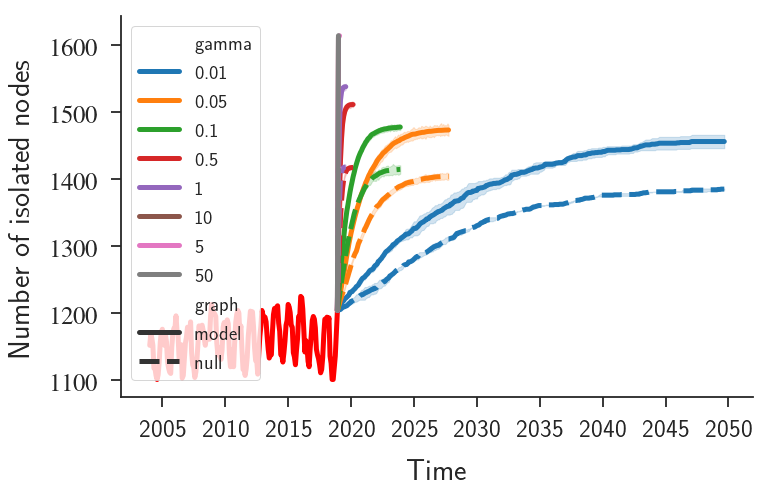

In [48]:
colors = sns.color_palette(None, 8)
fig,ax = plt.subplots(figsize=(xs,ys))
plt.plot(date_air,[len(list(nx.isolates(G))) for G in graphs_air],c='r')
g = sns.lineplot(x="time", y="Niso",hue='gamma', style='graph',palette=colors, legend = 'full', 
             ci=95,n_boot=100,data=df[df.Nend=='2000'],ax=ax)
plt.xlabel('Time')
plt.ylabel("Number of isolated nodes")
custom_frame(ax)
plt.show()

In [419]:
import collections

from scipy.stats import sem, t
from scipy import mean

def plot_mean_and_CI(mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    plt.fill_between(range(len(mean)), ub, lb,
                     color=color_shading, alpha=.5)
    # plot the mean on top
    plt.plot(mean, color_mean)
    
def get_survival_time(gamma,N_end):
    
    G = pickle.load(open(f'../simulation4/results/model_graphs_gamma{gamma}_Nend{N_end}0.pickle.dat','rb'))[0]
    edges_time = dict((edge,[]) for edge in list(G.edges()))
    files = glob.glob(f'../simulation4/results/model_graphs_gamma{gamma}_Nend{N_end}*.pickle.dat') + \
    glob.glob(f'../simulation4/results4/model_graphs_gamma{gamma}_Nend{N_end}*.pickle.dat')
    for f in files:
        graphs = pickle.load(open(f,'rb'))
        for edge in list(G.edges()):
            a = sum([g.has_edge(*edge) for g in graphs])-1
            edges_time[edge].append(a) 
            
    G = pickle.load(open(f'../simulation4/results/model_graphs_null_gamma{gamma}_Nend{N_end}0.pickle.dat','rb'))[0]
    edges_time_null = dict((edge,[]) for edge in list(G.edges()))
    files = glob.glob(f'../simulation4/results/model_graphs_null_gamma{gamma}_Nend{N_end}*.pickle.dat')+ \
    glob.glob(f'../simulation4/results4/model_graphs_null_gamma{gamma}_Nend{N_end}*.pickle.dat')    
    for f in files:
        graphs = pickle.load(open(f,'rb'))
        for edge in list(G.edges()):
            a = sum([g.has_edge(*edge) for g in graphs])-1
            edges_time_null[edge].append(a) 
    
    confidence = 0.95
    x,y_mean,y_up,y_low = [],[],[],[]
    for e,v in edges_time.items():
        x.append(e)
        n=len(v)
        std_err = sem(v)
        m = np.mean(v)
        h = std_err * t.ppf((1 + confidence) / 2, n - 1)
        y_mean.append(m)
        y_up.append(m+h)
        y_low.append(m-h)
    
    x = [i for _,i in sorted(zip(y_mean,x))]
    y_up = [i for _,i in sorted(zip(y_mean,y_up))]
    y_low = [i for _,i in sorted(zip(y_mean,y_low))]
    y_mean = sorted(y_mean)
    
#     y_mean_null,y_up_null,y_low_null = [],[],[]
#     for e in x:
#         v=edges_time_null[e]
#         std_err = sem(v)
#         m = np.mean(v)
#         h = std_err * t.ppf((1 + confidence) / 2, n - 1)
#         y_mean_null.append(m)
#         y_up_null.append(m+h)
#         y_low_null.append(m-h)

    confidence = 0.95
    x_null,y_mean_null,y_up_null,y_low_null = [],[],[],[]
    for e,v in edges_time_null.items():
        n=len(v)
        x_null.append(e)
        std_err = sem(v)
        m = np.mean(v)
        h = std_err * t.ppf((1 + confidence) / 2, n - 1)
        y_mean_null.append(m)
        y_up_null.append(m+h)
        y_low_null.append(m-h)
        
    x_null = [i for _,i in sorted(zip(y_mean_null,x_null))]
    y_up_null = [i for _,i in sorted(zip(y_mean_null,y_up_null))]
    y_low_null = [i for _,i in sorted(zip(y_mean_null,y_low_null))]
    y_mean_null = sorted(y_mean_null)
    
    return(x,y_mean,y_up,y_low,x_null,y_mean_null,y_up_null,y_low_null)    

def plot_survival_time(gamma,N_end,data,model=True):
    if model:
        x,y_mean,y_up,y_low=data[0:4]
        title = f'Model with $N =$ {N_end}, $\gamma =$ {gamma}'
        path = f'../figures//Fig5c_model_survival_exponential_Nend{N_end}_gamma{gamma}.pdf'
    else:
        x,y_mean,y_up,y_low=data[4::]
        title = f'Null with  $N =$ {N_end}, $\gamma =$ {gamma}'
        path = f'../figures//Fig5c_null_survival_exponential_Nend{N_end}_gamma{gamma}.pdf'
    
    fig,ax=plt.subplots(figsize=(xs*0.8,ys*0.8))
    plot_mean_and_CI(y_mean, y_up, y_low, color_mean='k', color_shading='grey')
    text_size =20
    index = 3002#x.index(('seattle_wa', 'santa_rosa_ca'))
    plt.scatter([index],[y_mean[index]],c='r',s=200,zorder=10)
    ax.annotate(f'({make_node_name(x[index][0])}' + ';\n' + f'{make_node_name(x[index][1])})',
                xy=(index, y_mean[index]), xycoords='data',size=text_size,
                xytext=(-65,-50), textcoords='offset pixels',
                arrowprops=dict(arrowstyle="->",color='r'))


    index = 1 #x.index(('san_diego_ca', 'mountain_view_ca'))
    plt.scatter([index],[y_mean[index]],c='r',s=200,zorder=10)
    ax.annotate(f'({make_node_name(x[index][0])}' + ';\n' + f'{make_node_name(x[index][1])})',
                xy=(index, y_mean[index]), xycoords='data',size=text_size,
                xytext=(50,-15), textcoords='offset pixels',
                arrowprops=dict(arrowstyle="->",color='r'))

#     index = x.index(('orlando_fl','chicago_il'))
#     plt.scatter([index],[y_mean[index]],c='r',s=200,zorder=10)
#     ax.annotate(f'({make_node_name(x[index][0])}' + ';\n' + f'{make_node_name(x[index][1])})',
#                 xy=(index, y_mean[index]), xycoords='data',size=20,
#                 xytext=(-50,-130), textcoords='offset pixels',
#                 arrowprops=dict(arrowstyle="->",color='r'))



    index = x.index(('new_york_ny','chicago_il'))
    plt.scatter([index],[y_mean[index]],c='r',s=200,zorder=10)
    ax.annotate(f'({make_node_name(x[index][0])}' + ';\n' + f'{make_node_name(x[index][1])})',
                xy=(index, y_mean[index]), xycoords='data',size=text_size,
                xytext=(-100,-100), textcoords='offset pixels',
                arrowprops=dict(arrowstyle="->",color='r'))
    
#     index = len(x)-1 #x.index(('new_york_ny','chicago_il'))
#     plt.scatter([index],[y_mean[index]],c='r',s=200,zorder=10)
#     ax.annotate(f'({make_node_name(x[index][0])}' + ';\n' + f'{make_node_name(x[index][1])})',
#                 xy=(index, y_mean[index]), xycoords='data',size=text_size,
#                 xytext=(-50,-130), textcoords='offset pixels',
#                 arrowprops=dict(arrowstyle="->",color='r'))
    
#     index = x.index(('new_york_ny','burlington_vt'))
#     plt.scatter([index],[y_mean[index]],c='r',s=200,zorder=10)
#     ax.annotate(f'({make_node_name(x[index][0])}' + ';\n' + f'{make_node_name(x[index][1])})',
#                 xy=(index, y_mean[index]), xycoords='data',size=20,
#                 xytext=(-60,100), textcoords='offset pixels',
#                 arrowprops=dict(arrowstyle="->",color='r'))
    show_edges = sorted([(i,j) for i,j in zip(edges,pred_prob_start) if center in i],key=lambda x: x[1],reverse=True)
#     show_edges = sorted([(i,j) for i,j in zip(edges,pred_prob_start) if center in i],key=lambda x: x[1],reverse=True)
#     show_edges = [i for i in show_edges if i[0] in list(G_end.edges())]
    show_edges_t = show_edges[0:1]+show_edges[-1:]
    for e,j in show_edges_t:
        index = x.index(e)
        plt.scatter([index],[y_mean[index]],c='r',s=200,zorder=10)
        ax.annotate(f'({make_node_name(x[index][0])}' + ';\n' + f'{make_node_name(x[index][1])})',
                xy=(index, y_mean[index]), xycoords='data',size=text_size,
                xytext=(-60,40), textcoords='offset pixels',
                arrowprops=dict(arrowstyle="->",color='r'))
#     plt.axhline(y=3000,linestyle='--',c='black')
    plt.title(title)
    plt.xlabel('Edge importance')
    plt.ylabel('Survival time (month)')
    custom_frame(ax)
    plt.tight_layout()
    plt.savefig(path,transparent=True)
    plt.show()

In [409]:
def new_plot_survival_time(gamma,N_end,data,model=True):
    if model:
        x,y_mean,y_up,y_low=data[0:4]
        title = f'Model with $N =$ {N_end}, $\gamma =$ {gamma}'
        path = f'../figures/Fig5c_model_survival_exponential_Nend{N_end}_gamma{gamma}.pdf'
    else:
        x,y_mean,y_up,y_low=data[4::]
        title = f'Null with  $N =$ {N_end}, $\gamma =$ {gamma}'
        path = f'../figures/Fig5c_null_survival_exponential_Nend{N_end}_gamma{gamma}.pdf'
    
    fig,ax=plt.subplots(figsize=(xs*0.7,ys*0.7))
    plot_mean_and_CI(y_mean, y_up, y_low, color_mean='k', color_shading='grey')
    text_size =20
    letters = ['a','b','c','d','e']
    link_list = [ x[1],
                ('burlington_vt', 'portland_me'),
                 x[3002],
                 ('atlanta_ga', 'burlington_vt'),
                ('new_york_ny','chicago_il')]
        
    index_list = [1,
                  3002,
                  x.index(('new_york_ny','chicago_il')),
                  x.index(('burlington_vt', 'portland_me')),
                  x.index(('atlanta_ga', 'burlington_vt'))]
    for index,letter,e in zip(index_list,letters,link_list):
    
        plt.scatter([index],[y_mean[index]],c='r',s=50,zorder=10)
        ax.annotate(letter,xy=(index, y_mean[index]), 
                    xycoords='data',
                    xytext=(10,-10), textcoords=('offset points', 'offset points'),
                    size=text_size,color='r')

    plt.title(title)
    plt.xlabel('Edge importance')
    plt.ylabel('Survival time (month)')
    custom_frame(ax)
    plt.tight_layout()
#     plt.savefig(path,transparent=True)
    plt.show()

In [332]:
data_1 = get_survival_time(0.05,2000)

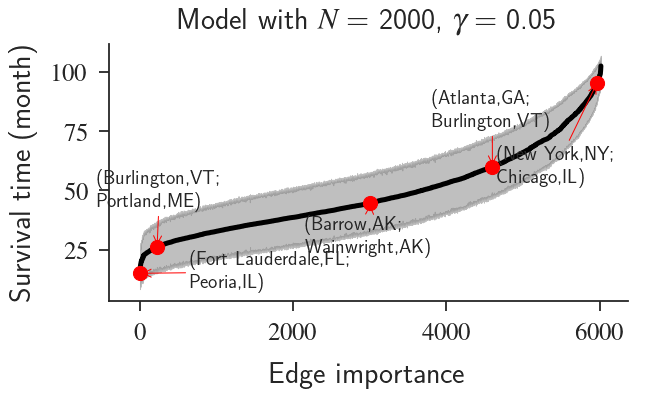

In [420]:
plot_survival_time(0.05,2000,data_1,model = True)

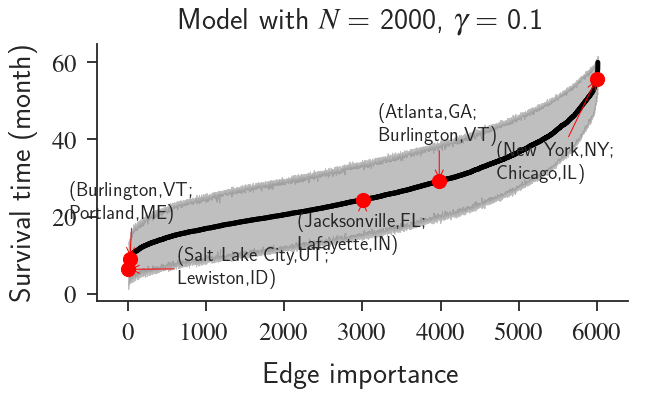

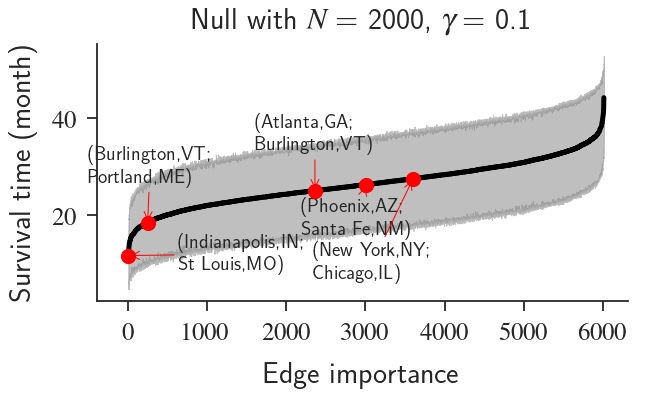

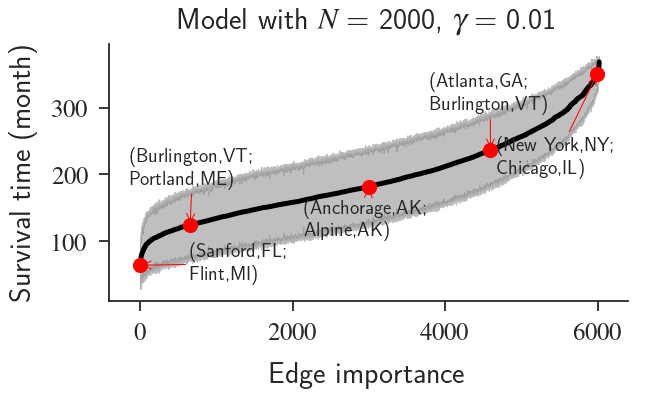

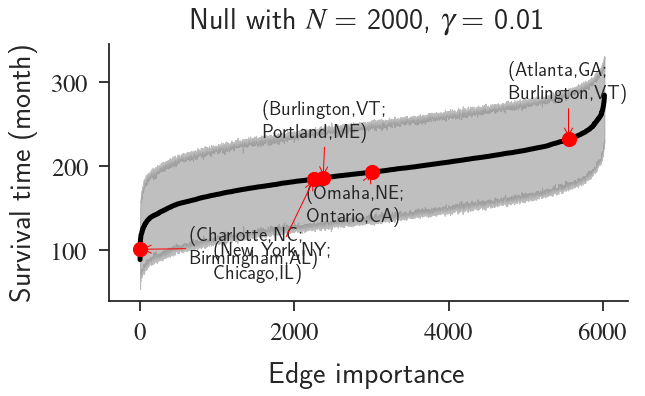

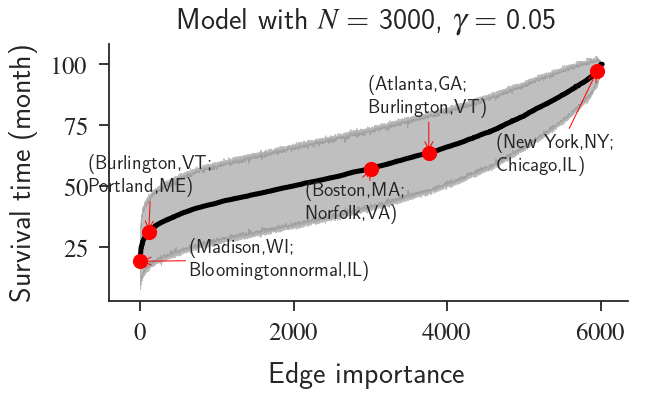

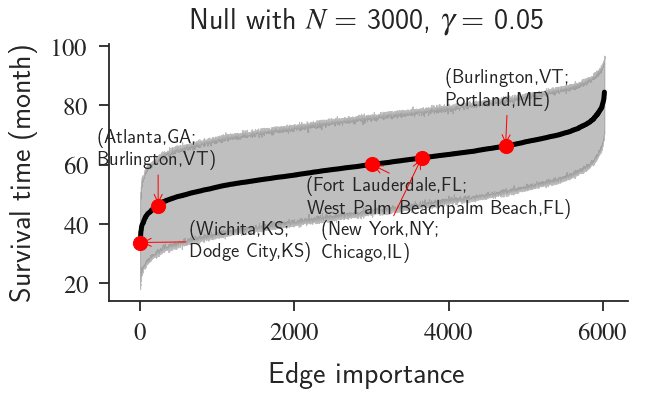

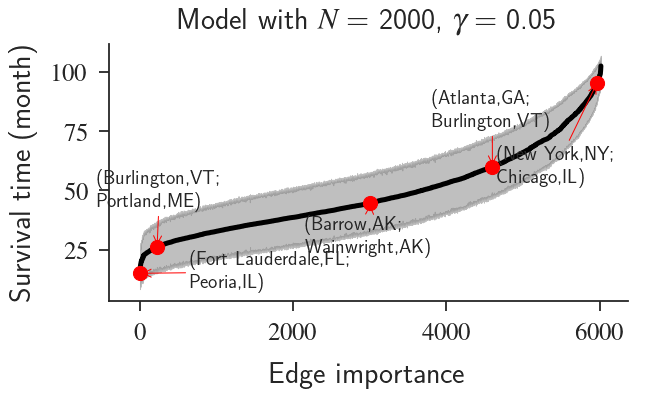

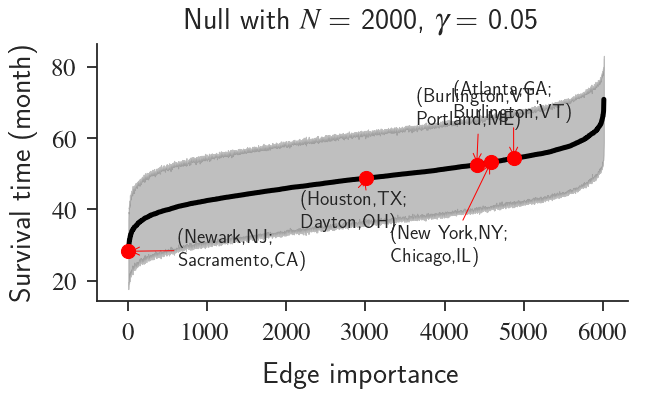

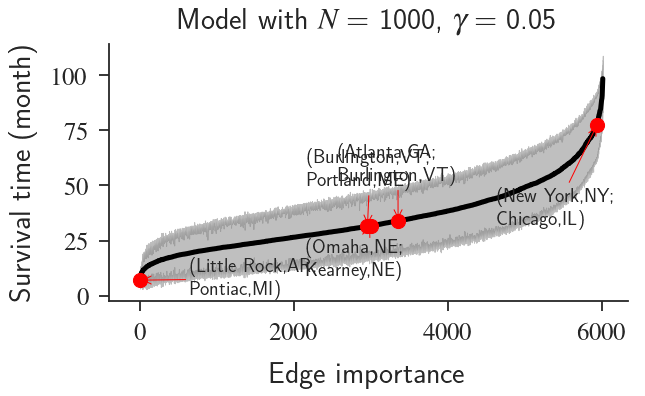

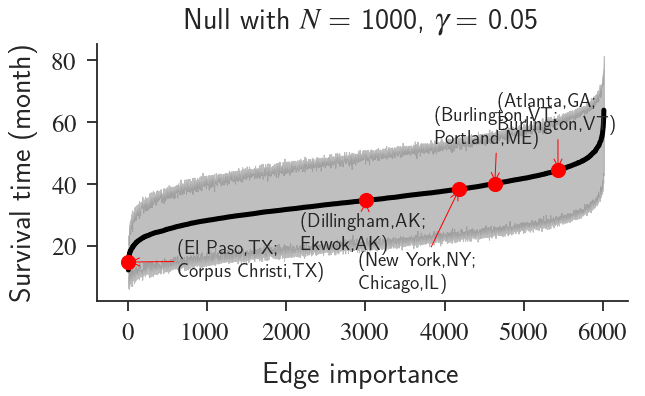

In [421]:
params = [(2000,0.1),(2000,0.01),(3000,0.05),(2000,0.05),(1000,0.05)]
for N_end,gamma in params:
#     try:
    data = get_survival_time(gamma,N_end)
    plot_survival_time(gamma,N_end,data,model = True)
    plot_survival_time(gamma,N_end,data,model = False)

In [12]:
gammas=[]
for f in files:
    if f.strip('.pickle.dat').split('_')[-1].strip('Nend')[0:4]=='2000':
        gammas.append(f.strip('.pickle.dat').split('_')[-2].strip('gamma'))
gammas=list(set(gammas))

In [9]:

files = glob.glob('../simulation4/results/*.pickle.dat')+ glob.glob('../simulation4/results0/*.pickle.dat')

params=[]
for f in files:
    N_end = f.strip('.pickle.dat').split('_')[-1].strip('Nend')[0:4]
    gamma = f.strip('.pickle.dat').split('_')[-2].strip('gamma')
    if (N_end,gamma) not in params:
        params.append((N_end,gamma))


In [ ]:
for rate in sorted(gammas):
    try:
        data_1 = get_survival_time(rate,2000)
    #     plot_survival_time(rate,data_1,model = True)
        plot_survival_time(rate,data_1,model = False)
    except:
        pass

In [ ]:
for rate in sorted(gammas):
    data_1 = get_survival_time(rate,1000)
    plot_survival_time(rate,1000,data_1,model = True)
#     plot_survival_time(rate,data_1,model = False)

In [67]:
def local_path(G,nodelist,epsilon = 0.01):
    A = nx.adjacency_matrix(G,weight=None).todense()
    return(A**2+epsilon*A**3)

def my_devide(a,b):
    if a!=0 and b!=0:
        return a/b
    else:
        return 0
def get_vector(G,edges):
    X,y = [],[]
    Ki = G.degree()
    nodelist = list(G.nodes())
    LPI = local_path(G,nodelist)
    NBs = dict([(u,set(G[u])) for u in G.nodes()])
    for e in edges:
        u,v = e
        union_size = len(NBs[u]|NBs[v])
        xi = []
        uv_intersection = list(nx.common_neighbors(G,u,v))
        xi.append(len(uv_intersection))
        xi.append(my_devide(len(uv_intersection),np.sqrt(Ki[u]*Ki[v])))
        xi.append(my_devide(len(uv_intersection),union_size))
        xi.append(my_devide(2*len(uv_intersection),(Ki[u]+Ki[v])))
        xi.append(my_devide(len(uv_intersection),min(Ki[u],Ki[v])))
        xi.append(my_devide(len(uv_intersection),max(Ki[u],Ki[v])))
        xi.append(my_devide(len(uv_intersection),(Ki[u]*Ki[v])))
        xi.append(Ki[u]*Ki[v])
        if len(uv_intersection) == 0:
            xi.append(0)
            xi.append(0)
        else:
            xi.append(sum([1/math.log(Ki[z]) for z in uv_intersection]))
            xi.append(sum(1/Ki[z] for z in uv_intersection))
        xi.append(LPI[nodelist.index(u),nodelist.index(v)])
        X.append(xi)
    return(X,y)

In [68]:
removal_model = pickle.load(open("../results/binary_removal_model.pickle.dat", "rb"))

In [141]:
gamma =0.05
N_end=2000
G_start = pickle.load(open(f'../simulation4/results/model_graphs_null_gamma{gamma}_Nend{N_end}0.pickle.dat','rb'))[0]
G_end = pickle.load(open(f'../simulation4/results/model_graphs_null_gamma{gamma}_Nend{N_end}0.pickle.dat','rb'))[-1]

In [62]:
x = dict(G_start.degree())
y = dict(G_end.degree())
x = {k: v for k, v in sorted(x.items(), key=lambda item: item[1])}
for k,v in x.items():
    if v < 20 and v> 10 and y[k]> 5 and y[k]<10:
        print(k)

state_college_pa
asheville_nc
ashland_wv
moline_il
trenton_nj
akron_oh
alexandria_la
bedford_ma
kodiak_ak
flint_mi
lafayette_la
myrtle_beach_sc
missionmcallenedinburg_tx
bellingham_wa
jacksonvicksburg_ms
lihue_hi
galena_ak
huntsville_al
burlington_vt
hayden_co
key_west_fl
kodiak_island_ak
great_falls_mt
jackson_wy
st_marys_ak
king_salmon_ak
san_bernardino_ca
chattanooga_tn
fort_wayne_in


In [69]:
edges = list(G_start.edges())
X,_ = get_vector(G_start,edges)

In [70]:
pred_prob_start = removal_model.predict_proba(X).T[1]

In [91]:
center = 'burlington_vt'
show_edges = sorted([(i,j) for i,j in zip(edges,pred_prob_start) if center in i],key=lambda x: x[1],reverse=True)
G = nx.Graph()
G.add_edges_from([i for i,_ in show_edges])
cor = nx.circular_layout(G)
pos = dict([(i[0][0],j) if i[0][1]==center else (i[0][1],j) for i,j in zip(show_edges,list(cor.values()))])
pos[center] = np.array([0,0])
label = dict([(i,make_node_name(i)) if i==center else (i,make_node_name(i)) for i in list(pos.keys())])
label[center] = make_node_name(center)
# pos = nx.spring_layout(G,k=100)
nx.set_node_attributes(G, dict([(i,j[0]) for i,j in pos.items()]), 'x')
nx.set_node_attributes(G, dict([(i,j[1]) for i,j in pos.items()]), 'y')
nx.set_node_attributes(G, dict([(i[0],j) if i[1]==center else (i[1],j) for i,j in show_edges]), 'pred')
# nx.write_gexf(G, '../results/G_start.gexf')

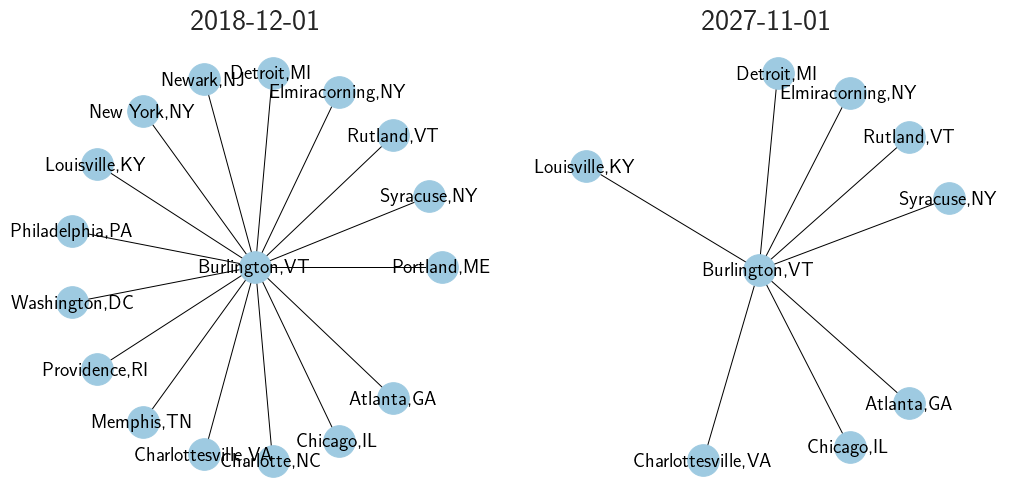

In [323]:
G_end = pickle.load(open(f'../simulation4/results/model_graphs_null_gamma{gamma}_Nend{N_end}21.pickle.dat','rb'))[-1]
add_time = len(pickle.load(open(f'../simulation4/results/model_graphs_null_gamma{gamma}_Nend{N_end}21.pickle.dat','rb')))
fig,ax = plt.subplots(1,2,figsize=(xs+3,ys))

plt.subplot(1,2,1)
#---------------
plt.title(f'{date_air[-1]}')
center = 'burlington_vt'
show_edges = sorted([(i,j) for i,j in zip(edges,pred_prob_start) if center in i],key=lambda x: x[1],reverse=True)

G = nx.Graph()
G.add_edges_from([i for i,_ in show_edges])


cor = nx.circular_layout(G)
pos = dict([(i[0][0],j) if i[0][1]==center else (i[0][1],j) for i,j in zip(show_edges,list(cor.values()))])
pos[center] = np.array([0,0])
label = dict([(i,make_node_name(i)) if i==center else (i,make_node_name(i)) for i in list(pos.keys())])
label[center] = make_node_name(center)
# label['west_palm_beachpalm_beach_fl']= make_node_name('west_palm_beach_fl')
# pos = nx.spring_layout(G,k=100)
nx.set_node_attributes(G, dict([(i,j[0]) for i,j in pos.items()]), 'x')
nx.set_node_attributes(G, dict([(i,j[1]) for i,j in pos.items()]), 'y')
nx.set_node_attributes(G, dict([(i[0],j) if i[1]==center else (i[1],j) for i,j in show_edges]), 'pred')
# nx.write_gexf(G, '../results/G_start.gexf')
#---------------
# nx.draw(G,pos=pos,labels=label,node_size = np.array(list(dict(G_start.degree()).values()))*10,node_color=[1]+[j for _,j in show_edges])
nx.draw(G,pos=pos,node_size =1000,font_size =20,labels=label,node_color='#9ecae1')
l,r = plt.xlim()
plt.xlim(l-0.2,r+0.2)



plt.subplot(1,2,2)
#---------------
plt.title(f'{add_months(date_air[-1],add_time)}')
show_edges = sorted([(i,j) for i,j in zip(edges,pred_prob_start) if center in i],key=lambda x: x[1],reverse=True)
show_edges = [i for i in show_edges if i[0] in list(G_end.edges())]
G = nx.Graph()
G.add_edges_from([i for i,_ in show_edges])
label = dict([(i,make_node_name(i)) if i==center else (i,make_node_name(i)) for i in list(pos.keys()) if i in list(G.nodes())]) 
label[center] = make_node_name(center)
# label['west_palm_beachpalm_beach_fl']= make_node_name('west_palm_beach_fl')
#---------------
# nx.draw(G,pos=pos,node_size = np.array(list(dict(G_end.degree()).values()))*10,labels=label,node_color=[0]+[j for _,j in show_edges])
nx.draw(G,pos=pos,node_size =1000,labels=label,font_size =20,node_color='#9ecae1')
l,r = plt.xlim()
plt.xlim(l-0.2,r+0.2)

# plt.xlim(l-d,r+d)
# l,r = plt.ylim()
# plt.ylim(l-d,r+d)
plt.tight_layout()
plt.savefig(f'../figures/fig5b.pdf',transparent=True)
plt.show()

In [87]:
G.edges

EdgeView([('key_west_fl', 'marathon_fl'), ('key_west_fl', 'fort_jefferson_fl'), ('key_west_fl', 'jacksonville_fl'), ('key_west_fl', 'sarasotabradenton_fl'), ('key_west_fl', 'newark_nj'), ('key_west_fl', 'tampa_fl'), ('key_west_fl', 'fort_myers_fl'), ('key_west_fl', 'washington_dc'), ('key_west_fl', 'west_palm_beachpalm_beach_fl'), ('key_west_fl', 'charlotte_nc'), ('key_west_fl', 'orlando_fl'), ('key_west_fl', 'miami_fl'), ('key_west_fl', 'dallasfort_worth_tx'), ('key_west_fl', 'atlanta_ga'), ('key_west_fl', 'fort_lauderdale_fl'), ('key_west_fl', 'chicago_il')])

In [93]:
show_edges = sorted([(i,j) for i,j in zip(edges,pred_prob_start) if center in i],key=lambda x: x[1],reverse=True)
show_edges = [i for i in show_edges if i[0] in list(G_end.edges())]
G = nx.Graph()
G.add_edges_from([i for i,_ in show_edges])
label = dict([(i,make_node_name(i)) if i==center else (i,make_node_name(i)) for i in list(pos.keys()) if i in list(G.nodes())]) 
label[center] = make_node_name(center)

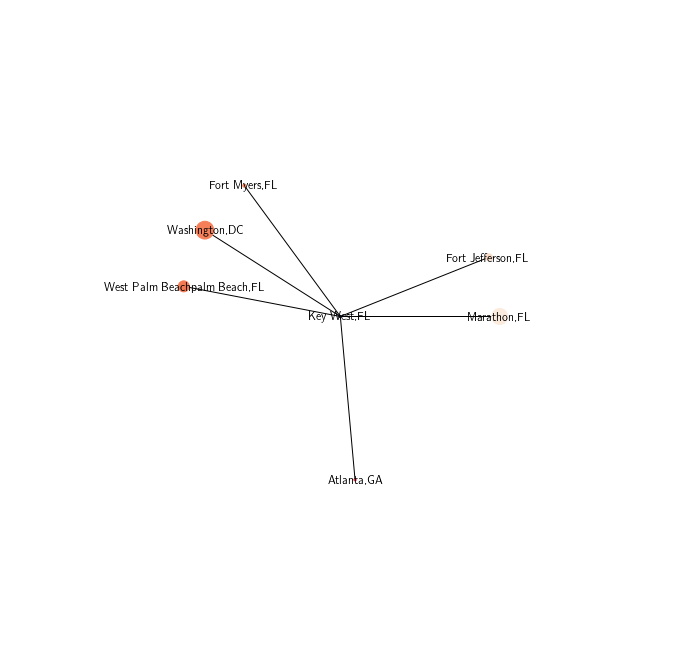

In [95]:
fig,ax = plt.subplots(figsize=(12,12))
nx.draw(G,pos=pos,node_size = np.array(list(dict(G_end.degree()).values()))*5,labels=label,node_color=[0]+[j for _,j in show_edges])
l,r = plt.xlim()
d=1
plt.xlim(l-d,r+d)
l,r = plt.ylim()
plt.ylim(l-d,r+d)
plt.show()

In [344]:
for rate in sorted(df.gamma.unique()):
    data_1 = get_survival_time(rate,1000)
#     plot_survival_time(rate,data_1,model = True)
    plot_survival_time(rate,data_1,model = False)

TypeError: plot_survival_time() missing 1 required positional argument: 'data'

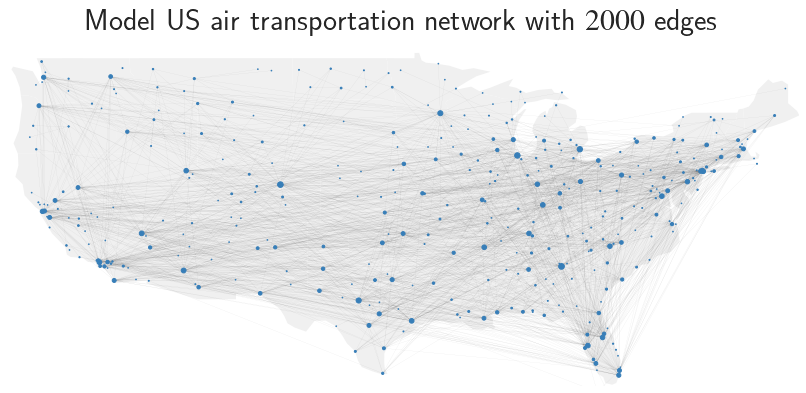

In [150]:
#function to convert node name to readable form

# import essential packages
import cartopy.crs as ccrs
import cartopy as cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
from cartopy.io import shapereader
from matplotlib.lines import Line2D

def make_node_name(node):
    node = node.title()
    text = node.split('_')    
    if len(text)<3:
        return ','.join([text[0],text[1].upper()])
    else:
        city = ' '.join(text[0:-1])
        state = text[-1]
        state = state.upper()
        return ','.join([city,state])

#nodes position information
pos = pd.read_pickle('../data/US_air_geo_information.pkl')

#prepare labels for edges
labels = ['Retained Edge', 'Removed Edge'] # this order is fixed
colors = ['black', 'red']
styles = ['solid', 'dashed']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle= s) for c,s in zip(colors,styles)]

#select snapshot for displaying 
year = date(2014,1,1)
gamma =0.05
N_end=2000
G = pickle.load(open(f'../simulation4/results/model_graphs_null_gamma{gamma}_Nend{N_end}0.pickle.dat','rb'))[-1]
G.remove_nodes_from(['payson_az','hanapepe_hi'])

#edges separation
## the edges that are in mainland us
edges_in_land = [edge for edge in G.edges() if (pos[edge[0]].lng >= -128 and pos[edge[0]].lng <= -65 and pos[edge[1]].lng >= -128 and pos[edge[1]].lng <=-65)]
edges_in_land = [edge for edge in edges_in_land if (pos[edge[0]].lat >= 23 and pos[edge[1]].lat >= 23)]


#plot
border = [-125,-67,25,50] # xmin_xmax_ymin_ymax
# sizey = 8
# sizex = sizey * (border[1]-border[0])/(border[3]-border[2])
sizex = stdfigsize(ratio=-1)[0]
sizey = sizex*(border[3]-border[2])/(border[1]-border[0])
fig = plt.figure(figsize=(xs,ys))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)

shp = shapereader.Reader(states_shp)
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
for record, state in zip(shp.records(), shp.geometries()):
    name = record.attributes['name']
    facecolor = '#f0f0f0'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor='none',zorder=-1)
ax.set_extent(border, crs=ccrs.PlateCarree())

#draw edges
nx.draw(G,
        pos = pos,
        width= 0.1,
        alpha= 0.2,
        node_size = 0,
        edgelist= edges_in_land,
        edge_color = 'black',
        style = 'solid')

#draw nodes
nx.draw(G,
        pos = pos,
        node_color = '#377eb8',
        width= 0,
        alpha= 1,
        node_size = np.array(list(dict(G.degree()).values()))/2)

ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
plt.title('Model US air transportation network with $2000$ edges')
plt.tight_layout()
plt.savefig('../figures/model_us_air_graphs_result.png',bbox_inches='tight',dpi=500,transparent=True)
plt.show()